In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/Snakes in the hood')

In [3]:
%tensorflow_version 2.x

## Unzip source files

In [ ]:
! unzip '/content/drive/My Drive/Colab Notebooks/Snakes in the hood/8a95c26e1bab11eb.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/b70a166bfe.jpg  
  inflating: dataset/train/d31875b68e.jpg  
  inflating: dataset/train/22c66793fb.jpg  
  inflating: dataset/train/a468b1390f.jpg  
  inflating: dataset/train/9e43d2cedc.jpg  
  inflating: dataset/train/2e0299e991.jpg  
  inflating: dataset/train/e0b85d8ff1.jpg  
  inflating: dataset/train/6a651ec04a.jpg  
  inflating: dataset/train/46c87716a5.jpg  
  inflating: dataset/train/8c40d4f073.jpg  
  inflating: dataset/train/96e4fb744c.jpg  
  inflating: dataset/train/794a698960.jpg  
  inflating: dataset/train/dad1934f35.jpg  
  inflating: dataset/train/a1c66a2b3c.jpg  
  inflating: dataset/train/b62484a8e4.jpg  
  inflating: dataset/train/09462814f1.jpg  
  inflating: dataset/train/97dbdb4dd0.jpg  
  inflating: dataset/train/3bd7f56164.jpg  
  inflating: dataset/train/a2576a2fa1.jpg  
  inflating: dataset/train/f462f66aa6.jpg  
  inflating: dataset/train/740e1a7fca.jpg  
  inflating: dataset/trai

## Importing Packages

In [4]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from learningratefinder import LearningRateFinder

## Helper Functions

In [5]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Load datasets from the NPZ file

In [6]:
processed_dataset = np.load('/content/drive/My Drive/Colab Notebooks/Snakes in the hood/Snake_images_dataset.npz', allow_pickle=True)

Xtrain, Ytrain = processed_dataset['Xtrain64'], processed_dataset['Ytrain64']
#Xpredict = processed_dataset['Xpredict']

Ytrain_oh = to_categorical(Ytrain, 35)

print("------------------------- Training Dataset -------------------------")
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))
print("Ytrain_oh shape: {}".format(Ytrain_oh.shape))

#print("\n------------------------- Prediction Dataset -------------------------")
#print("Xpredict shape: {}".format(Xpredict.shape))

del processed_dataset
gc.collect()

------------------------- Training Dataset -------------------------
Xtrain shape: (1315, 64, 128, 3)
Ytrain shape: (1315, 1)
Ytrain_oh shape: (1315, 35)


6

## Autoencoder

### Split training data into train/ test datasets

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=10)
for train_index, test_index in sss.split(Xtrain, Ytrain):
    Xtrain, Xtest = Xtrain[train_index], Xtrain[test_index]
    Ytrain, Ytest = Ytrain[train_index], Ytrain[test_index]

print("------------------------- Training Dataset -------------------------")
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

------------------------- Training Dataset -------------------------
Xtrain shape: (1117, 64, 128, 3)
Ytrain shape: (1117, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (198, 64, 128, 3)
Ytest shape: (198, 1)


### Build the model

In [22]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()        
        
        # Encoder
        x_input = Input(shape=(None, None, 3))

        x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x_input)
        x = BatchNormalization()(x)
        x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        encoded = BatchNormalization()(x)
        
        self.encoder = Model(inputs=x_input, outputs=encoded, name='Encoder')
        print(self.encoder.summary())

        #Decoder
        encoded_inputs = Input(shape=(None, None, 512))

        x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(encoded_inputs)
        x = BatchNormalization()(x)
        x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)

        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)

        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)

        x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                   activation='swish', kernel_regularizer=l2(0.0001),
                   kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)
        
        decoded = Conv2D(filters=3, kernel_size=3, strides=1, padding='same', 
                         activation='sigmoid', kernel_regularizer=l2(0.0001),
                         kernel_initializer='he_uniform')(x)
        
        self.decoder = Model(inputs=encoded_inputs, outputs=decoded, name='Decoder')
        print(self.decoder.summary())

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [23]:
# Define the model hyperparameters
mini_batch_size = 128

# Create and compile the model
autoencoder = Autoencoder()
autoencoder.compile(loss='mean_squared_error', metrics=['accuracy'],
                    optimizer=Lookahead(AdamW(lr=1e-2, 
                                              weight_decay=1e-5, 
                                              clipvalue=700), 
                                        sync_period=10))

# Early stopping policy
early = EarlyStopping(monitor="val_loss", mode="min", 
                      restore_best_weights=True, 
                      patience=20, verbose=1)

# Reduce LR on plateau policy
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-5, patience=10, 
                              verbose=1, mode='min')

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_54 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, None, None, 64)    1849

### Train and validate the model

In [12]:
# Learning Rate Finder
lrf = LearningRateFinder(autoencoder)
lrf.find((Xtrain, Xtrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

Epoch 1/228
9/9 [==============================] - 7s 831ms/step - loss: 0.7566 - accuracy: 0.3583
Epoch 2/228
9/9 [==============================] - 3s 335ms/step - loss: 0.7565 - accuracy: 0.3588
Epoch 3/228
9/9 [==============================] - 3s 342ms/step - loss: 0.7564 - accuracy: 0.3580
Epoch 4/228
9/9 [==============================] - 3s 345ms/step - loss: 0.7563 - accuracy: 0.3582
Epoch 5/228
9/9 [==============================] - 3s 340ms/step - loss: 0.7564 - accuracy: 0.3591
Epoch 6/228
1/9 [==>...........................] - ETA: 0s - loss: 0.7676 - accuracy: 0.3551

KeyboardInterrupt: ignored

In [24]:
# Fit the model
history = autoencoder.fit(x=Xtrain, y=Xtrain, batch_size=mini_batch_size,
                          epochs=512, verbose=1, workers=5,
                          callbacks=[reduce_lr, early], 
                          validation_data=(Xtest, Xtest))

Epoch 1/512
9/9 [==============================] - 9s 947ms/step - loss: 0.8753 - accuracy: 0.3455 - val_loss: 1.4579 - val_accuracy: 0.6941
Epoch 2/512
9/9 [==============================] - 5s 534ms/step - loss: 0.5063 - accuracy: 0.6663 - val_loss: 0.9210 - val_accuracy: 0.6941
Epoch 3/512
9/9 [==============================] - 5s 530ms/step - loss: 0.3090 - accuracy: 0.6352 - val_loss: 0.8176 - val_accuracy: 0.6941
Epoch 4/512
9/9 [==============================] - 5s 534ms/step - loss: 0.2185 - accuracy: 0.6347 - val_loss: 0.7701 - val_accuracy: 0.6862
Epoch 5/512
9/9 [==============================] - 5s 528ms/step - loss: 0.1671 - accuracy: 0.6653 - val_loss: 0.6723 - val_accuracy: 0.6103
Epoch 6/512
9/9 [==============================] - 5s 528ms/step - loss: 0.1436 - accuracy: 0.6682 - val_loss: 0.7449 - val_accuracy: 0.6941
Epoch 7/512
9/9 [==============================] - 5s 525ms/step - loss: 0.1529 - accuracy: 0.6759 - val_loss: 0.7362 - val_accuracy: 0.6874
Epoch 8/512
9

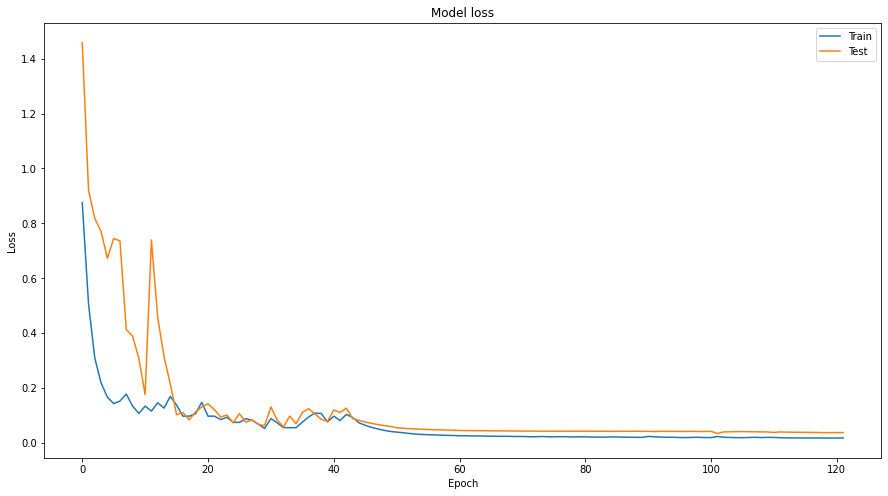

In [25]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Validate autoencoder images

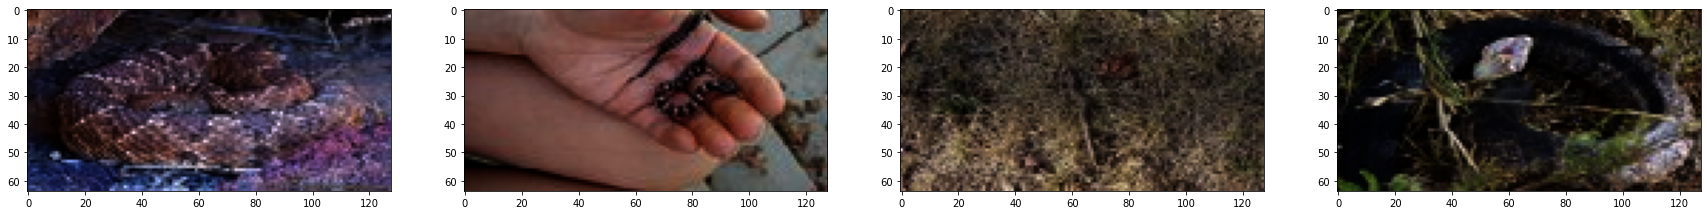

In [26]:
_, ax = plt.subplots(1, 4, figsize=(30, 30))
ax[0].imshow(Xtrain[10])
ax[1].imshow(Xtrain[100])
ax[2].imshow(Xtrain[500])
ax[3].imshow(Xtrain[1000])

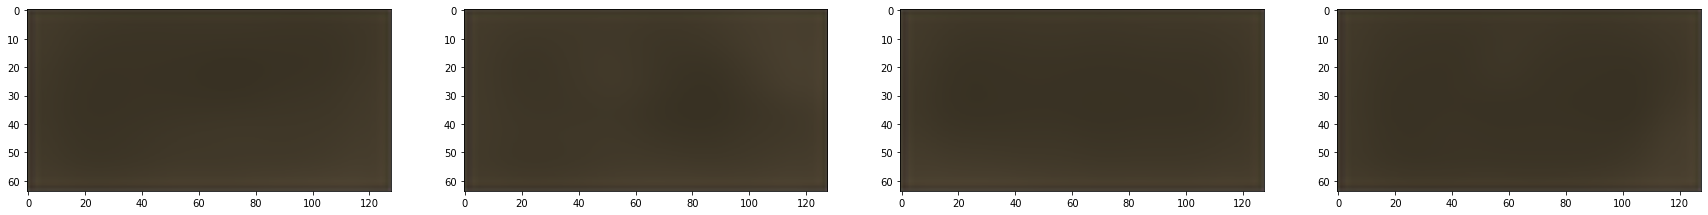

In [27]:
_, ax = plt.subplots(1, 4, figsize=(30, 10))
ax[0].imshow(np.squeeze(autoencoder.predict(np.expand_dims(Xtrain[10], axis=0)), axis=0))
ax[1].imshow(np.squeeze(autoencoder.predict(np.expand_dims(Xtrain[100], axis=0)), axis=0))
ax[2].imshow(np.squeeze(autoencoder.predict(np.expand_dims(Xtrain[500], axis=0)), axis=0))
ax[3].imshow(np.squeeze(autoencoder.predict(np.expand_dims(Xtrain[1000], axis=0)), axis=0))

### Save the autoencoder model

In [28]:
autoencoder.save('/content/drive/My Drive/Colab Notebooks/Snakes in the hood/autoencoder_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Snakes in the hood/autoencoder_model/assets


## Final Model

### Load the autoencoder model (for transfer learning)

In [29]:
autoencoder = load_model('/content/drive/My Drive/Colab Notebooks/Snakes in the hood/autoencoder_model')

In [30]:
autoencoder.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_54 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, None, None, 64)    1849

### Build the model

In [31]:
def head(x_input):

    x = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', 
               activation='swish', kernel_regularizer=l2(0.0001),
               kernel_initializer='he_uniform')(x_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=1024, kernel_size=1, strides=1, padding='same', 
               activation='swish', kernel_regularizer=l2(0.0001),
               kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=35, kernel_size=1, strides=1, padding='same', 
               activation='linear', kernel_regularizer=l2(0.0001),
               kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax')(x)

    return x

In [32]:
# Define the model hyperparameters
mini_batch_size = 128

# Build the model
encoder = autoencoder.encoder
encoded = encoder.layers[-1].output
model = Model(encoder.input, head(encoded))

'''
# Freeze weights for encoder section of final model
for layer in encoder.layers:
    layer.trainable = False
'''

# Compile the final model
model.compile(loss='categorical_crossentropy', 
              metrics=[F1Score(num_classes=35, average='weighted'), 
                       'categorical_accuracy'],
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_54 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, None, None, 64)   

Epoch 1/47
44/44 [==============================] - 37s 843ms/step - loss: 13.3508 - f1_score: 0.0333 - categorical_accuracy: 0.0310
Epoch 2/47
44/44 [==============================] - 36s 826ms/step - loss: 13.2893 - f1_score: 0.0332 - categorical_accuracy: 0.0314
Epoch 3/47
44/44 [==============================] - 36s 829ms/step - loss: 13.3334 - f1_score: 0.0361 - categorical_accuracy: 0.0329
Epoch 4/47
44/44 [==============================] - 36s 824ms/step - loss: 13.3388 - f1_score: 0.0301 - categorical_accuracy: 0.0285
Epoch 5/47
44/44 [==============================] - 36s 829ms/step - loss: 13.2597 - f1_score: 0.0346 - categorical_accuracy: 0.0314
Epoch 6/47
44/44 [==============================] - 37s 830ms/step - loss: 13.3124 - f1_score: 0.0293 - categorical_accuracy: 0.0274
Epoch 7/47
44/44 [==============================] - 36s 829ms/step - loss: 13.3056 - f1_score: 0.0309 - categorical_accuracy: 0.0294
Epoch 8/47
44/44 [==============================] - 36s 829ms/step - 

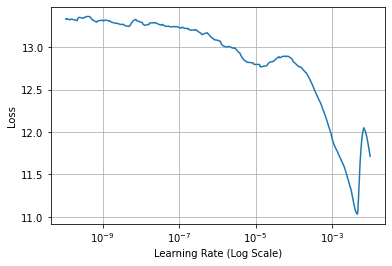

In [ ]:
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find((Xtrain, Ytrain_oh),
         startLR=1e-10, endLR=1e-2,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()

In [33]:
class_weight = {
    0: 0.18181818181818182,
    1: 0.4210526315789474,
    2: 0.07207207207207206,
    3: 0.09195402298850575,
    4: 0.15686274509803919,
    5: 0.08602150537634408,
    6: 0.13793103448275862,
    7: 0.20512820512820512,
    8: 0.2962962962962963,
    9: 0.25806451612903225,
    10: 0.13559322033898305,
    11: 0.4,
    12: 0.4,
    13: 0.3076923076923077,
    14: 0.26666666666666666,
    15: 1.0,
    16: 0.13559322033898305,
    17: 0.22222222222222218,
    18: 0.25806451612903225,
    19: 0.6666666666666666,
    20: 0.6666666666666666,
    21: 0.27586206896551724,
    22: 0.3076923076923077,
    23: 0.23529411764705882,
    24: 0.36363636363636365,
    25: 0.3333333333333333,
    26: 0.22222222222222218,
    27: 0.19047619047619047,
    28: 0.1142857142857143,
    29: 0.25,
    30: 0.2285714285714286,
    31: 0.3333333333333333,
    32: 0.4,
    33: 0.32,
    34: 0.34782608695652173
}

In [36]:
# Train the model using K-fold
counter = 0
oof_f1_score = 0
#y_pred_final = 0
loss_values = {}
f1_values = {}

# Define K-fold cross validation test harness
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=10)

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain_oh[train]
    val_x, val_y = Xtrain[val], Ytrain_oh[val]

    # Build the model
    encoder = autoencoder.encoder
    encoded = encoder.layers[-1].output
    final_model = Model(encoder.input, head(encoded))

    '''
    # Freeze weights for encoder section of final model
    for layer in encoder.layers:
        layer.trainable = False
    '''

    # Configure data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        shear_range=0.15,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        vertical_flip=True,
        fill_mode="nearest")

    # Compile model to configure the learning process
    final_model.compile(loss='categorical_crossentropy', 
                        metrics=[F1Score(num_classes=35, average='weighted'), 
                                 'categorical_accuracy'],
                        optimizer=Lookahead(AdamW(lr=1e-3, 
                                                  weight_decay=1e-5, 
                                                  clipvalue=700), 
                                            sync_period=10))

    # Early stopping policy
    early = EarlyStopping(monitor="val_categorical_accuracy", mode="min", 
                          restore_best_weights=True, 
                          patience=20, verbose=1)

    # Reduce LR on plateau policy
    reduce_lr = ReduceLROnPlateau(monitor="val_categorical_accuracy", 
                                  factor=0.1, min_lr=1e-7, patience=10, 
                                  verbose=1, mode='min')

    # Fit the model
    history = final_model.fit(
        datagen.flow(train_x, train_y, batch_size=mini_batch_size),
        steps_per_epoch=int(np.ceil(train_x.shape[0] / float(mini_batch_size))),
        class_weight=class_weight, epochs=512, verbose=1, workers=5,
        callbacks=[reduce_lr, early], validation_data=(val_x, val_y)
    )
    
    # Get validation metrics
    y_pred = final_model.predict(val_x)
    y_pred = np.array([np.argmax(y_pred, axis=1)]).T
    y_true = np.array([np.argmax(val_y, axis=1)]).T
    score = f1_score(y_true, y_pred, average='weighted')

    # Make predictions
    #y_pred_final += final_model.predict(Xpredict)

    # Store the model loss and f1 values
    loss_values["train_loss_"+str(counter)] = history.history['loss']
    loss_values["val_loss_"+str(counter)] = history.history['val_loss']
    f1_values["train_f1_"+str(counter)] = history.history['f1_score']
    f1_values["val_f1_"+str(counter)] = history.history['val_f1_score']

    print("Fold-{} | F1-Score: {}".format(counter, score))
    oof_f1_score += score

#y_pred_final /= float(counter)
oof_f1_score /= float(counter)
y_pred_final = np.array([np.argmax(y_pred_final, axis=1)]).T
print("Aggregate F1-Score: {}".format(oof_f1_score))

Epoch 1/512
8/8 [==============================] - 4s 481ms/step - loss: 1.2231 - f1_score: 0.0139 - categorical_accuracy: 0.0157 - val_loss: 11.7045 - val_f1_score: 0.0036 - val_categorical_accuracy: 0.0250
Epoch 2/512
8/8 [==============================] - 1s 186ms/step - loss: 1.1646 - f1_score: 0.0269 - categorical_accuracy: 0.0355 - val_loss: 6.6092 - val_f1_score: 0.0133 - val_categorical_accuracy: 0.0250
Epoch 3/512
8/8 [==============================] - 1s 185ms/step - loss: 1.1393 - f1_score: 0.0201 - categorical_accuracy: 0.0303 - val_loss: 6.0336 - val_f1_score: 0.0129 - val_categorical_accuracy: 0.0312
Epoch 4/512
8/8 [==============================] - 1s 185ms/step - loss: 1.1233 - f1_score: 0.0201 - categorical_accuracy: 0.0334 - val_loss: 5.4312 - val_f1_score: 0.0134 - val_categorical_accuracy: 0.0312
Epoch 5/512
8/8 [==============================] - 2s 189ms/step - loss: 1.1068 - f1_score: 0.0253 - categorical_accuracy: 0.0387 - val_loss: 5.0536 - val_f1_score: 0.0137

KeyboardInterrupt: ignored

In [ ]:
print(classification_report(Ytrain, y_pred_final))

In [ ]:
cnf_matrix = confusion_matrix(Ytrain, y_pred_final)
np.set_printoptions(precision=2)
plt.figure(figsize=(15,11))
plot_confusion_matrix(cnf_matrix)

### Learning Curves

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_values["train_loss_1"], label='train_loss_1')
plt.plot(loss_values["train_loss_2"], label='train_loss_2')
plt.plot(loss_values["train_loss_3"], label='train_loss_3')
plt.plot(loss_values["train_loss_4"], label='train_loss_4')
plt.plot(loss_values["train_loss_5"], label='train_loss_5')
plt.plot(loss_values["train_loss_6"], label='train_loss_6')
plt.plot(loss_values["train_loss_7"], label='train_loss_7')
plt.plot(loss_values["val_loss_1"], label='val_loss_1')
plt.plot(loss_values["val_loss_2"], label='val_loss_2')
plt.plot(loss_values["val_loss_3"], label='val_loss_3')
plt.plot(loss_values["val_loss_4"], label='val_loss_4')
plt.plot(loss_values["val_loss_5"], label='val_loss_5')
plt.plot(loss_values["val_loss_6"], label='val_loss_6')
plt.plot(loss_values["val_loss_7"], label='val_loss_7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(f1_values["train_f1_1"], label='train_f1_1')
plt.plot(f1_values["train_f1_2"], label='train_f1_2')
plt.plot(f1_values["train_f1_3"], label='train_f1_3')
plt.plot(f1_values["train_f1_4"], label='train_f1_4')
plt.plot(f1_values["train_f1_5"], label='train_f1_5')
plt.plot(f1_values["train_f1_6"], label='train_f1_6')
plt.plot(f1_values["train_f1_7"], label='train_f1_7')
plt.plot(f1_values["val_f1_1"], label='val_f1_1')
plt.plot(f1_values["val_f1_2"], label='val_f1_2')
plt.plot(f1_values["val_f1_3"], label='val_f1_3')
plt.plot(f1_values["val_f1_4"], label='val_f1_4')
plt.plot(f1_values["val_f1_5"], label='val_f1_5')
plt.plot(f1_values["val_f1_6"], label='val_f1_6')
plt.plot(f1_values["val_f1_7"], label='val_f1_7')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Model F1-Score Curve")
plt.legend()
plt.grid()
plt.show()

## Create submission file

In [ ]:
predict_df = pd.read_csv("dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['image_id'] = predict_df['image_id']
submit_df['breed'] = y_pred_final

In [ ]:
snakes_map = {
    0: 'nerodia-erythrogaster',
    1: 'pantherophis-vulpinus',
    2: 'thamnophis-sirtalis',
    3: 'pantherophis-obsoletus',
    4: 'agkistrodon-contortrix',
    5: 'crotalus-atrox',
    6: 'lampropeltis-triangulum',
    7: 'crotalus-horridus',
    8: 'crotalus-ruber',
    9: 'heterodon-platirhinos',
    10: 'nerodia-sipedon',
    11: 'thamnophis-elegans',
    12: 'thamnophis-marcianus',
    13: 'crotalus-viridis',
    14: 'nerodia-fasciata',
    15: 'haldea-striatula',
    16: 'storeria-dekayi',
    17: 'agkistrodon-piscivorus',
    18: 'nerodia-rhombifer',
    19: 'storeria-occipitomaculata',
    20: 'thamnophis-radix',
    21: 'coluber-constrictor',
    22: 'natrix-natrix',
    23: 'diadophis-punctatus',
    24: 'masticophis-flagellum',
    25: 'pantherophis-spiloides',
    26: 'rhinocheilus-lecontei',
    27: 'lampropeltis-californiae',
    28: 'pituophis-catenifer',
    29: 'opheodrys-aestivus',
    30: 'pantherophis-guttatus',
    31: 'pantherophis-alleghaniensis',
    32: 'thamnophis-proximus',
    33: 'pantherophis-emoryi',
    34: 'crotalus-scutulatus'
}

In [ ]:
submit_df['breed'] = submit_df['breed'].map(snakes_map)
submit_df.head()

In [ ]:
submit_df.to_csv("/content/drive/My Drive/Colab Notebooks/Snakes in the hood/Predictions/prediction_v1.csv", index=False)